#### Goal :: Predict the sale (number of items) for the shop-item pair in the  test set. The test set is for one month - November 2015 

In [86]:
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from datetime import datetime, timedelta, date
from calendar import monthrange
from pytz import timezone
import pandas as pd
import numpy as np
import feather
import datetime
import pytz
import csv
import os
import matplotlib.pyplot as plt


%matplotlib inline

def get_dates_in_month(year, month, time_zone):
    num_days = monthrange(year, month)[1]
    first_date_of_month = datetime.datetime(year,month,1, tzinfo=time_zone)
    last_date_of_month =  datetime.datetime(year,month,num_days, tzinfo=time_zone)
    return get_dates_inrange(first_date_of_month, last_date_of_month)


def get_dates_inrange(date1, date2):
    if (not isinstance(date1, datetime.datetime)) | (not isinstance(date2, datetime.datetime)):
        return "date1 and date2 should be of type datetime.date"
    num_days = (date2 - date1).days + 1
    date_list = [date1 + datetime.timedelta(days=x) for x in range(0, num_days)]
    return date_list

In [87]:
DATA_FOLDER = './'

sales    = pd.read_csv(os.path.join(DATA_FOLDER, 'sales_train.csv.gz'))
items           = pd.read_csv(os.path.join(DATA_FOLDER, 'items.csv'))
item_categories = pd.read_csv(os.path.join(DATA_FOLDER, 'item_categories.csv'))
shops           = pd.read_csv(os.path.join(DATA_FOLDER, 'shops.csv'))
date_df = pd.read_pickle("russian_holidays.pkl")
geography = pd.read_csv('geography.csv')
test = pd.read_csv(os.path.join(DATA_FOLDER, 'test.csv.gz'))
holiday_filepath = 'hol.feather'
holidays = feather.read_dataframe(holiday_filepath)

(2935849, 6)
(214200, 3)


Total Items: 22170
Total Categories: 84
Total Shops: 60

--------------------------------------------------------

Training data
  # unique shops: 60
  # unique items: 21807

--------------------------------------------------------

Test data
  # unique shops: 42
  # unique items: 5100


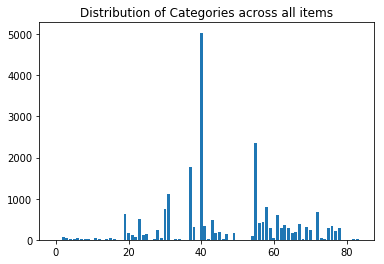

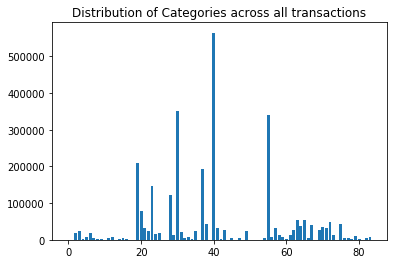

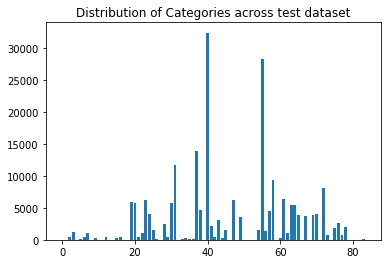




# items in test set: 5100
# items in test set and transaction set: 4737
# items in test but not transaction: 363


# shops in test set: 42
# shops in test set and transaction set: 42
# shops in test but not transaction: 0




In [88]:
print(sales.shape)
print(test.shape)
print("\n")
print("Total Items: {}".format(items.item_id.nunique()))
print("Total Categories: {}".format(item_categories.item_category_id.nunique()))
print("Total Shops: {}".format(shops.shop_id.nunique()))
print("\n--------------------------------------------------------\n")

print("Training data")
print("  # unique shops: {}".format(sales.shop_id.nunique()))
print("  # unique items: {}".format(sales.item_id.nunique()))

print("\n--------------------------------------------------------\n")
print("Test data")
print("  # unique shops: {}".format(test.shop_id.nunique()))
print("  # unique items: {}".format(test.item_id.nunique()))


%matplotlib inline
transactions = sales
# Drop the rows with price lt zero. ther is only one.
transactions = transactions[transactions.item_price > 0]

# Merging to get category_id in the transaction df
transactions = pd.merge(transactions, items[['item_id', 'item_category_id']], on='item_id', how='left')

unique_categories, count = np.unique(items.item_category_id, return_counts=True)
ax = plt.subplot()
ax.bar(unique_categories, count)    
plt.title( "Distribution of Categories across all items")
plt.show()

unique_categories_trans, count_trans = np.unique(transactions.item_category_id, return_counts=True)
ax = plt.subplot()
ax.bar(unique_categories_trans, count_trans)
plt.title("Distribution of Categories across all transactions")
plt.show()

test_mod = pd.merge(test, items[['item_id', 'item_category_id']], on='item_id', how='left')
unique_categories_test, count_test = np.unique(test_mod.item_category_id, return_counts=True)
ax = plt.subplot()
ax.bar(unique_categories_test, count_test)
plt.title("Distribution of Categories across test dataset")
plt.show()

print("\n\n")

items_test_nottrans = len(set(test.item_id.unique()) - set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
intersection_items_test_transac = len(set(test.item_id.unique()).intersection(set(transactions.item_id.unique())))
item_count_test = len(set(test.item_id.unique()))

print("# items in test set: {}".format(item_count_test))
print("# items in test set and transaction set: {}".format(intersection_items_test_transac))
print("# items in test but not transaction: {}".format(items_test_nottrans))

print("\n")

shops_test_nottrans = len(set(test.shop_id.unique()) - set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
intersection_shops_test_transac = len(set(test.shop_id.unique()).intersection(set(transactions.shop_id.unique())))
shop_count_test = len(set(test.shop_id.unique()))

print("# shops in test set: {}".format(shop_count_test))
print("# shops in test set and transaction set: {}".format(intersection_shops_test_transac))
print("# shops in test but not transaction: {}".format(shops_test_nottrans))

print("\n")

##### Building the shops data frame

In [89]:
# Setting the shop_type
shop_types = ['ТЦ', 'ТРК', 'ТРЦ', 'МТРЦ', 'ТК']
shops["shop_type"] = shops.shop_name.apply(lambda x: x.split()[1] if x.split()[1] in shop_types else 'OTH')

# Setting the city for each shop
shops["city"] = shops.shop_name.apply(lambda x: x.split()[0].replace("!", ""))

# Appending the geographic info to shops df
shops = pd.merge(shops, geography.drop(['city_eng'], axis=1), on='city', how='inner')

print(shops.shape)
catg = ['shop_type', 'city', 'fed_subject', 'fed_dist']
for c in catg:
    shops[c] = shops[c].astype('category')

shops.head()
# t, c = np.unique(shops.shop_type, return_counts=True)

# print(t)
# print(c)

(60, 8)


,shop_name,shop_id,shop_type,city,time_wrt_utc,fed_subject,fed_dist,dist_from_moscow
0,"!Якутск Орджоникидзе, 56 фран",0,OTH,Якутск,9,Sakha Republic,Far East,8395
1,"!Якутск ТЦ ""Центральный"" фран",1,ТЦ,Якутск,9,Sakha Republic,Far East,8395
2,"Якутск Орджоникидзе, 56",57,OTH,Якутск,9,Sakha Republic,Far East,8395
3,"Якутск ТЦ ""Центральный""",58,ТЦ,Якутск,9,Sakha Republic,Far East,8395
4,"Адыгея ТЦ ""Мега""",2,ТЦ,Адыгея,3,Adygea Republic,South,1589


Выездная Торговля	9	OTH	Выездная	-1	NaN	NaN	-1          (exit trade)

Интернет-магазин ЧС	12	OTH	Интернет-магазин	-1	NaN	NaN	-1   (Online shop Emergency)

Цифровой склад 1С-Онлайн	55	OTH	Цифровой	-1	NaN	NaN	-1 (Digital warehouse 1C-Online)

#### Building a date df, and block_num_info df for adding temporal data.

In [5]:
# setting up the calendar and the Block_num info dataframe

moscow = timezone('Europe/Moscow')
train_first_date = datetime.datetime(2013,1,1, tzinfo=moscow)
train_last_date =  datetime.datetime(2015,11,30, tzinfo=moscow)

date_df = pd.DataFrame(get_dates_inrange(train_first_date, train_last_date), columns=['date'])

date_df['weekday'] = date_df['date'].apply(lambda x: x.isoweekday())
date_df['is_weekend'] = date_df['weekday'] > 5

# Holidays dataframe - (preparing df)
holidays_b = holidays
holidays_b['date_str'] = holidays_b.date.apply(lambda x: x.isoformat().split("T")[0])
holidays_b['off_day'] =  holidays_b.h_type.apply(lambda x: x.split(",")[0] == 'National holiday')
holidays_b['is_holiday'] = True

date_df['date_str'] = date_df.date.apply(lambda x: x.isoformat().split("T")[0])

date_df = pd.merge(date_df, holidays_b[['date_str', 'is_holiday']], on='date_str', how='left')
date_df['is_holiday'].fillna(False, inplace=True)

date_df = pd.merge(date_df, holidays_b[['off_day', 'date_str']], on='date_str', how='left')
date_df.loc[date_df.loc[:, 'weekday'] > 5, 'off_day'] = True


def add_date_block_num(d):
    if(d.year == 2013):
        base=0
    elif(d.year == 2014):
        base=12
    elif(d.year == 2015): 
        base=24
    return base + (d.month-1)

date_df['date_block_num'] = date_df['date'].apply(lambda x: add_date_block_num(x))

date_df.head()


# Block info df
block_num_info = date_df[date_df.is_weekend == True].groupby('date_block_num')['is_weekend'].sum().reset_index(name = "weekends")

block_num_info['holidays'] = date_df[date_df.is_holiday == True].groupby('date_block_num')['is_holiday'].sum()
block_num_info['holidays'].fillna(0, inplace=True)

block_num_info['off_days'] = date_df[date_df.off_day == True].groupby('date_block_num')['off_day'].sum()
block_num_info['off_days'].fillna(0, inplace=True)

block_num_info.head()

,date_block_num,weekends,holidays,off_days
0,0,8.0,7.0,14
1,1,8.0,2.0,8
2,2,10.0,2.0,11
3,3,8.0,0.0,8
4,4,8.0,9.0,16


#### Build the initial training df

In [6]:
# 'sales' is the input training dataframe
sales.head()

,date,date_block_num,shop_id,item_id,item_price,item_cnt_day
0,02.01.2013,0,59,22154,999.00,1.0
1,03.01.2013,0,25,2552,899.00,1.0
2,05.01.2013,0,25,2552,899.00,-1.0
3,06.01.2013,0,25,2554,1709.05,1.0
4,15.01.2013,0,25,2555,1099.00,1.0


In [7]:


# remove date column
sales_monthly = sales.drop(['date'], axis=1)

# Aggregating item_cnt_day (summing) and item_price(averaging)
agg_funcs = {'item_cnt_day':np.sum, 'item_price':np.mean}
sales_monthly = sales_monthly.groupby(['date_block_num', 'shop_id', 'item_id']).agg(agg_funcs).reset_index()

# rename the columns
sales_monthly.rename(columns={'item_price':'item_avg_price', 'item_cnt_day':'item_cnt_month'}, inplace=True)

# Adding seasonality - month numbers (jan1, feb-2, march-3....dec-12)
sales_monthly['month'] = (sales_monthly['date_block_num'] % 12)+1

# Appending shop information
sales_monthly = pd.merge(sales_monthly, shops, on='shop_id', how='left')

# Appending block_num_info (temporal features)
sales_monthly = pd.merge(sales_monthly, block_num_info, on='date_block_num', how='left')

# Appending item info
sales_monthly = pd.merge(sales_monthly, items, on='item_id', how='left')

print(sales_monthly.shape)

(1609124, 18)


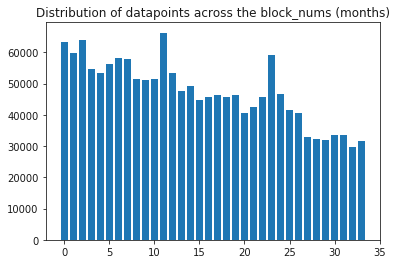

In [147]:
import seaborn as sns

plt.clf()

y = list(sales_monthly.groupby(['date_block_num']).size())
x = list(range(0,len(y)))

test_mod = pd.merge(test, items[['item_id', 'item_category_id']], on='item_id', how='left')
unique_categories_test, count_test = np.unique(test_mod.item_category_id, return_counts=True)
ax = plt.subplot()
ax.bar(x, y)
plt.title("Distribution of datapoints across the block_nums (months)")
plt.show()

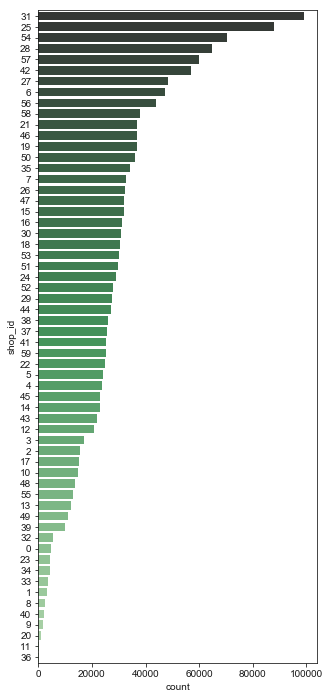

In [148]:
plt.clf()

# Plot the shopi-transactions
sns.set_color_codes("muted")
f, ax = plt.subplots(figsize=(5, 12))
sns.set(font_scale=1.5)

sns.countplot(y="shop_id", data=sales_monthly, palette="Greens_d", order = sales_monthly['shop_id'].value_counts().index)

# Add a legend and informative axis label
# ax.legend(ncol=4, loc="lower right", frameon=True)
# ax.set(ylabel="Shop-ID", xlabel="transactions")
# sns.despine(left=True, bottom=True)

plt.show()


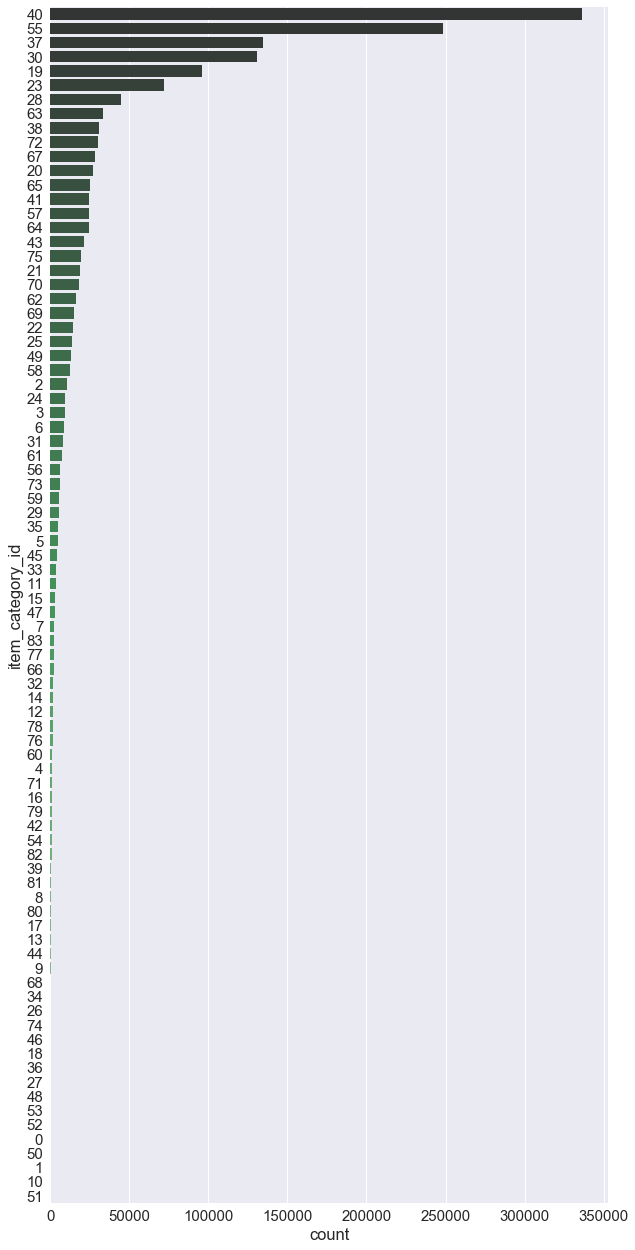

In [150]:
plt.clf()

# Plot the shopi-transactions
sns.set_color_codes("muted")
f, ax = plt.subplots(figsize=(10, 22))
sns.set(font_scale=1.5)

sns.countplot(y="item_category_id", data=sales_monthly, palette="Greens_d", order = sales_monthly['item_category_id'].value_counts().index)

plt.show()


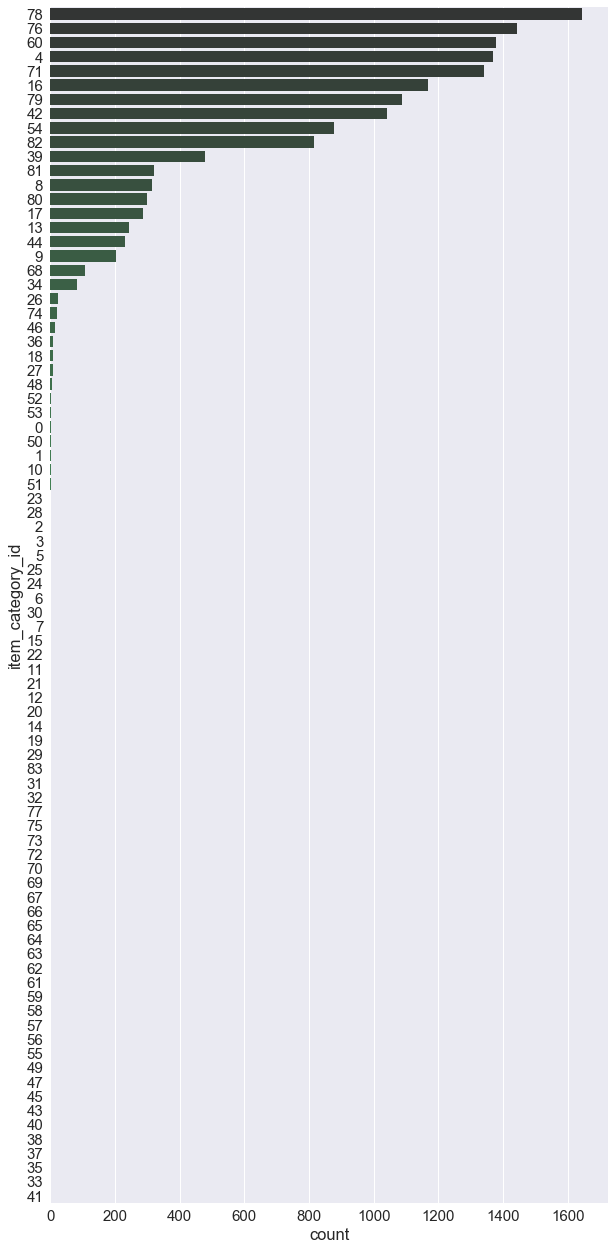

In [179]:
item_catgs = [51, 10, 1, 50, 0, 52, 53, 48, 27, 36, 18, 46, 74, 26, 34, 68, 9, 44, 13,
              17, 80, 8, 81, 39, 82, 54, 42, 79, 16, 71, 4, 60, 76, 78]

plt.clf()

# Plot the shopi-transactions
sns.set_color_codes("muted")
f, ax = plt.subplots(figsize=(10, 22))
sns.set(font_scale=1.5)
df = sales_monthly[sales_monthly['item_category_id'].isin(item_catgs)]

sns.countplot(y="item_category_id", data=sales_monthly[sales_monthly['item_category_id'].isin(item_catgs)],
              palette="Greens_d", order = df['item_category_id'].value_counts().index)

plt.show()

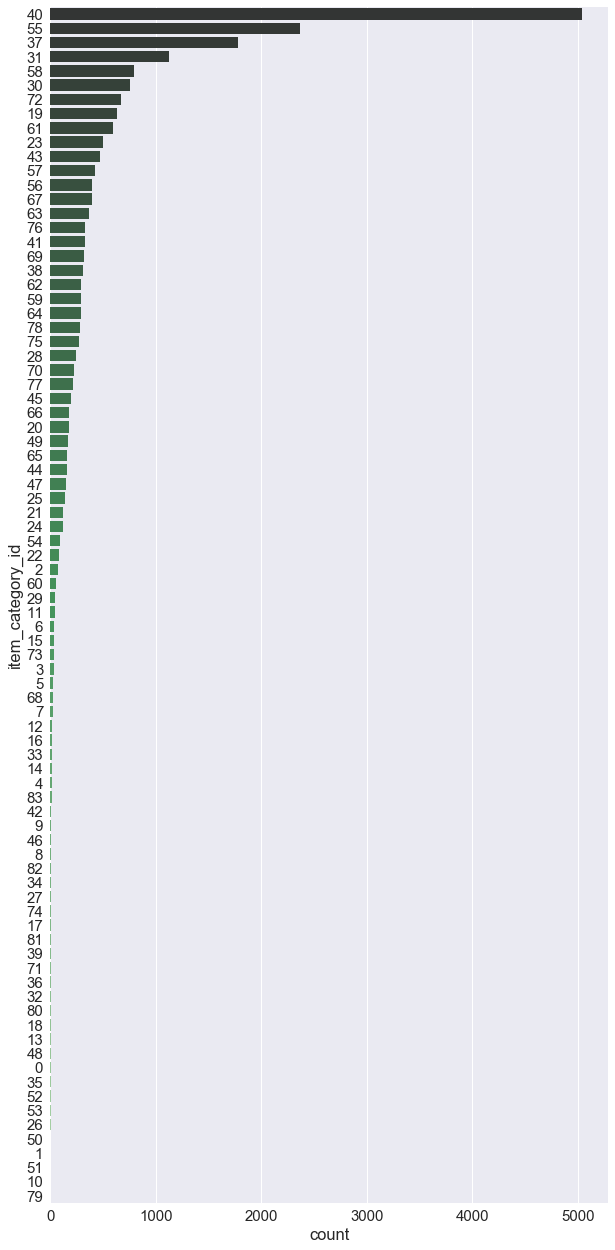

In [177]:
plt.clf()

# Plot the shopi-transactions
sns.set_color_codes("muted")
f, ax = plt.subplots(figsize=(10, 22))
sns.set(font_scale=1.5)

sns.countplot(y="item_category_id", data=items, palette="Greens_d", order = items['item_category_id'].value_counts().index)

plt.show()


In [178]:
items['item_category_id'].value_counts()

40    5035
55    2365
37    1780
31    1125
58     790
30     756
72     666
19     628
61     598
23     501
43     471
57     427
56     397
67     394
63     366
76     333
41     332
69     317
38     310
62     295
59     294
64     290
78     278
75     277
28     240
70     228
77     220
45     195
66     178
20     175
      ... 
4       15
83      15
42      12
9       12
46      12
8        9
82       8
34       8
27       8
74       8
17       7
81       7
39       7
71       6
36       6
32       6
80       6
18       6
13       6
48       5
0        4
35       4
52       3
53       3
26       3
50       2
1        2
51       1
10       1
79       1
Name: item_category_id, Length: 84, dtype: int64

In [9]:
# Feature  List

numeric_var = list(["item_avg_price", "dist_from_moscow", "holidays", "off_days"])
categ_var = list(['shop_id' , 'shop_type', 'time_wrt_utc',  "weekends", 'city', 'fed_subject', 'fed_dist', 'item_category_id', 'item_id'])
text_var  = list(['item_name', 'shop_name'])
temporal_var = list(['date_block_num', 'month' ])
target_var = 'item_cnt_month'

sales_monthly[categ_var] = sales_monthly[categ_var].apply(lambda x: x.astype('category'))
sales_monthly[numeric_var] = sales_monthly[numeric_var].apply(lambda x: pd.to_numeric(x, downcast='float'))
sales_monthly[text_var] = sales_monthly[text_var].apply(lambda x: x.astype('str'))
sales_monthly[temporal_var] = sales_monthly[temporal_var].apply(lambda x: x.astype('int'))

sales_monthly.head(4)

,date_block_num,shop_id,item_id,item_cnt_month,item_avg_price,month,shop_name,shop_type,city,time_wrt_utc,fed_subject,fed_dist,dist_from_moscow,weekends,holidays,off_days,item_name,item_category_id
0,0,0,32,6.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9,Sakha Republic,Far East,8395.0,8.0,7.0,14.0,1+1,40
1,0,0,33,3.0,347.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9,Sakha Republic,Far East,8395.0,8.0,7.0,14.0,1+1 (BD),37
2,0,0,35,1.0,247.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9,Sakha Republic,Far East,8395.0,8.0,7.0,14.0,10 ЛЕТ СПУСТЯ,40
3,0,0,43,1.0,221.0,1,"!Якутск Орджоникидзе, 56 фран",OTH,Якутск,9,Sakha Republic,Far East,8395.0,8.0,7.0,14.0,100 МИЛЛИОНОВ ЕВРО,40


#### To Do:

For training:

1. replace Item id by item tf-idf dtm features --- INCOMPLETE
2. Handle categorical features - statistical target encoding, label encoding etc (some encoding!)
3. get rid of temporal features month, block_num - DONE -- see the train-validation set [17]
4. get rid of shop name - DONE
5. scale the training features.

For test dataset:

1. calculate avg. price for the items in test data set
2. Append shop features
3. Append item tf-idf dtm features

In [110]:
sales_monthly.shop_id.dtype

category

In [130]:
len(sales_monthly[sales_monthly['shop_id'].isin([12])])

20742

In [72]:
# Single Train-Validation set
b = 12 # Training on: blocks[0:11], Validation on: block# 12

x_train = sales_monthly[sales_monthly['date_block_num'] < b][numeric_var + categ_var + text_var]
y_train = sales_monthly[sales_monthly['date_block_num'] < b][target_var]

x_val = sales_monthly[sales_monthly['date_block_num'] == b][numeric_var + categ_var + text_var]
y_val = sales_monthly[sales_monthly['date_block_num'] == b][target_var]

In [73]:
# Preprocessing of features for Linear Regression. 
a = set(list(x_train.shop_id.unique()))
b = set(list(x_val.shop_id.unique()))

In [74]:
print(a)
print(len(a))
print(b)

{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 35, 37, 38, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59}
52
{2, 3, 4, 5, 6, 7, 10, 12, 13, 14, 15, 16, 17, 18, 19, 21, 22, 24, 25, 26, 27, 28, 29, 30, 31, 35, 37, 38, 41, 42, 43, 44, 45, 46, 47, 49, 50, 51, 52, 53, 54, 55, 56, 57, 58, 59}


In [19]:
a ^ b

{0, 1, 8, 9, 23, 32}